<a href="https://colab.research.google.com/github/eriktaylor/Transformer-introduction/blob/main/DYNOv2_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import urllib.request
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision.transforms import v2

In [6]:
#load images from wikimedia

url_list = ["https://upload.wikimedia.org/wikipedia/commons/thumb/1/1d/Dog_%28Canis_lupus_familiaris%29_%285%29.JPG/640px-Dog_%28Canis_lupus_familiaris%29_%285%29.JPG",
            "https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/Dhole%28Asiatic_wild_dog%29.jpg/640px-Dhole%28Asiatic_wild_dog%29.jpg",
            "https://upload.wikimedia.org/wikipedia/commons/thumb/9/92/Male_Bolognese_Dog_Walking.jpg/640px-Male_Bolognese_Dog_Walking.jpg",
            "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/Greenland_467_%2835130903436%29_%28cropped%29.jpg/640px-Greenland_467_%2835130903436%29_%28cropped%29.jpg"]

file_list = []

for val, url in enumerate(url_list):
  filename = f"dog_{val}.jpg"
  file_list.append(filename)
  urllib.request.urlretrieve(url, filename)


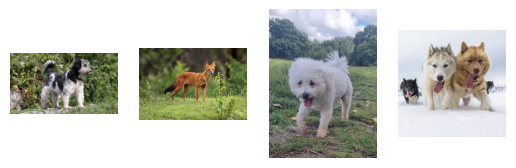

In [7]:
#view the PIL images before transforms

fig, axs = plt.subplots(1, len(file_list))

for i in range(len(file_list)):
  axs[i].imshow(Image.open(file_list[i]))
  axs[i].axis('off')  # Turn off axis labels

plt.show()

In [8]:
transform = v2.Compose([
              v2.Resize(560, interpolation=v2.InterpolationMode.BICUBIC),
              v2.CenterCrop(560),
              v2.ToTensor(),
              v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ])

batch_size = len(file_list)
imgs_tensor = torch.zeros(batch_size, 3, 560, 560)

for i in range(batch_size):
    img = Image.open(file_list[i])
    imgs_tensor[i] = transform(img)

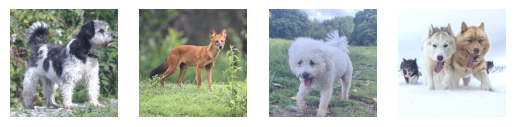

In [13]:
#To view the images after transforms, need to reverse normalization

fig, axs = plt.subplots(1, len(file_list))

for i in range(len(file_list)):
  img_t = (imgs_tensor[i]+imgs_tensor[i].max())/(imgs_tensor[i].max()-imgs_tensor[i].min())
  axs[i].imshow(img_t.permute(1,2,0))
  axs[i].axis('off')  # Turn off axis labels

plt.show()

In [14]:
#load large DinoV2 model
dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dino.cuda()

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitl14_pretrain.pth
100%|██████████| 1.13G/1.13G [00:07<00:00, 167MB/s] 


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x NestedTensorBlock(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )


In [15]:
#Inference
with torch.no_grad():
  features_dict = dino.forward_features(imgs_tensor.cuda())
  features = features_dict['x_norm_patchtokens']
  #features = features_dict['x_prenorm']

print("before reshape", features.shape)
_, n_patch, dim = features.shape
features = features.reshape(batch_size*n_patch, dim)
print("after reshape", features.shape)

before reshape torch.Size([4, 1600, 1024])
after reshape torch.Size([6400, 1024])


In [16]:
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [17]:
features = features.cpu()
pca = PCA(n_components=1)
scaler = MinMaxScaler()
pca.fit(features)
pca_features = pca.transform(features)
norm_features = scaler.fit_transform(pca_features)

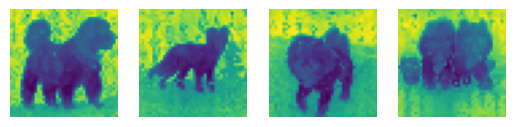

In [18]:
#view the normalized features after transforms

fig, axs = plt.subplots(1, batch_size)

for i in range(batch_size):
  img = pca_features[i * n_patch: (i+1) * n_patch, 0].reshape(40, 40)
  axs[i].imshow(img)
  axs[i].axis('off')  # Turn off axis labels

plt.show()

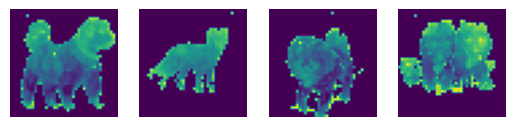

In [19]:
# Remove background
threshold = 0.5 #for ViTl/14
background = norm_features > threshold #Adjust threshold based on your images

fig, axs = plt.subplots(1, batch_size)

for i in range(batch_size):
  img = norm_features[i * n_patch: (i+1) * n_patch]
  #mask = background[i * n_patch: (i+1) * n_patch]
  img[img>threshold] = 0
  axs[i].imshow(img.reshape(40, 40))
  axs[i].axis('off')  # Turn off axis labels

plt.show()

In [20]:
#set background of features to zero

bg_features = features.clone() #make a copy of features
for i in range(bg_features.shape[-1]):
  bg_features[:,i][background[:,0]] = 0

In [21]:
#fit 3 components
pca3 = PCA(n_components=3)
pca3.fit(bg_features)
features_foreground = pca3.transform(bg_features)
norm_features_foreground = scaler.fit_transform(features_foreground)

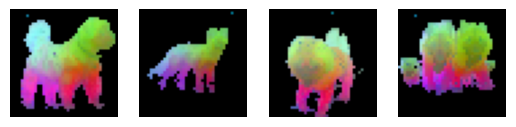

In [22]:
fig, axs = plt.subplots(1, batch_size)

for i in range(batch_size):
  img = norm_features_foreground[i * n_patch: (i+1) * n_patch]
  mask = background[i * n_patch: (i+1) * n_patch]
  for j in range(3):
    img[:,j][mask[:,0]]=0
  axs[i].imshow(img.reshape(40, 40,3))
  axs[i].axis('off')  # Turn off axis labels

plt.show()